In [1]:
#installing the neessary package 
! pip install -q 'gwosc==0.5.4' 
#checking which version was installed
import gwosc

! pip install -q lalsuite
! pip install -q gwpy
! pip install -q pycbc
! pip install matplotlib==3.1.3
! pip install -q 'lalsuite==6.82' 'PyCBC==1.18.0'


from google.colab import drive

import numpy as np
import matplotlib.pyplot as plt
import numpy
import pylab

import pycbc.types 
from pycbc.types import TimeSeries

import pycbc.noise

import pycbc.psd
from pycbc.psd import interpolate, inverse_spectrum_truncation

import pycbc.filter
from pycbc.filter import resample_to_delta_t, highpass, matched_filter

import pycbc.waveform
from pycbc.waveform import get_td_waveform

#loading the data from the drive
drive.mount('/content/drive')

pycbc_strain = pycbc.types.load_timeseries('/content/drive/MyDrive/GW_noisedata-2.npy')

  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.1
    Uninstalling matplotlib-3.5.1:
      Successfully uninstalled matplotlib-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gwpy 2.1.3 requires matplotlib>=3.3.0, but you have matplotlib 3.1.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [18]:
#Variables necessary to do the following operations

#solar masses for this exercise
# equal mass range (5, 10)
m = np.arange(5,10,0.1) # Mass range bewteen 5 to  10 (format arguments: start, stop, step)
m1 = m2 = m

#choosing an approximant to create the template
apx = "TaylorF2"

#defining teh sample rate and the data length 
sample_rate = 2048 # samples per second
data_length = 1024 # seconds
delta_t = 1/sample_rate
#defining the lower cut off frequency
f_low = 15 #Hz
#step for the mass iteration 
step = 0.1
mass = numpy.arange(5,10+step,step) 



In [19]:
#Preconditioning the data
# First the low frequency content is removed and the data is downsampled to 2048Hz

pycbc_strain = highpass(pycbc_strain, 15.0)
pycbc_strain = resample_to_delta_t(pycbc_strain, 1.0/2048)

# To condition the data, 2 seconds of data are removed from both the beginning and end 
conditioned_strain = pycbc_strain.crop(2,2)


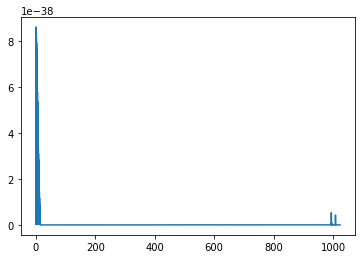

In [13]:
#Plot the noise power spectral density (PSD) of that data.
# Estimating the power spectral density again, this time with the preconditioned data to make the SNR calculation easier

# We use 4 second samples of our time series in Welch method, which takes pieces of data and combines then
psd = conditioned_strain.psd(4)

#After having created our new psd, it is necessary to interpolate it so it properly matches our data and to limit the filter length of 1/PSD
 
psd = interpolate(psd, conditioned_strain.delta_f)

#As we have have highpassed our frequency with 15 and thus excluded frequencies below that, our low frequency cut off is at 15 Hz.
psd = inverse_spectrum_truncation(psd, int(4 * pycbc_strain.sample_rate),
                                  low_frequency_cutoff=f_low)
#plotting the psd
plt.plot(psd.sample_frequencies, psd)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: ComplexWarning: Casting complex values to real discards the imaginary part



 => The highest SNR value has been found at [1.18700868e+09] s: SNR value = 5.37466025676849.


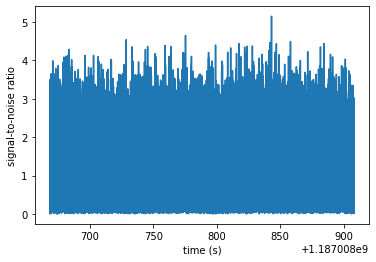

Maximum SNR 5.145075211056601
[[ 0.00000000e+00 -1.98963631e+00  1.18700885e+09]
 [ 0.00000000e+00 -4.45419701e+00  1.18700887e+09]
 [ 0.00000000e+00 -3.75167169e+00  1.18700882e+09]
 [ 0.00000000e+00  5.37466026e+00  1.18700868e+09]
 [ 0.00000000e+00  3.21590417e+00  1.18700870e+09]
 [ 0.00000000e+00 -4.67939386e+00  1.18700877e+09]
 [ 0.00000000e+00 -2.95270152e+00  1.18700872e+09]
 [ 0.00000000e+00  2.91737258e+00  1.18700871e+09]
 [ 0.00000000e+00 -2.80546959e+00  1.18700877e+09]
 [ 0.00000000e+00 -3.32467765e+00  1.18700870e+09]
 [ 0.00000000e+00 -5.04335694e+00  1.18700884e+09]
 [ 0.00000000e+00 -2.16643858e+00  1.18700887e+09]
 [ 0.00000000e+00 -5.25479206e+00  1.18700878e+09]
 [ 0.00000000e+00  3.32022898e+00  1.18700886e+09]
 [ 0.00000000e+00 -1.27771119e+00  1.18700889e+09]
 [ 0.00000000e+00  4.86901084e+00  1.18700885e+09]
 [ 0.00000000e+00 -2.79222883e+00  1.18700885e+09]
 [ 0.00000000e+00  3.92631308e+00  1.18700883e+09]
 [ 0.00000000e+00  4.35068709e+00  1.18700888e+09]
 

In [20]:
#Testing whether there is any gravitational wave signal present in the data #


#first a list needs to be initialised
SNR_list = numpy.zeros((len(mass), 3), float)# We will later use this list to store the max SNR for every mass



#To iterate through all the masses, I have created a loop to go through all values for the mass 

for x in range(0, len(mass)): 
  #creating the template for the different masses 
 
  hp, _ = get_td_waveform(approximant='TaylorF2',
                          mass1=mass[x],
                          mass2=mass[x],
                          delta_t=1.0/sample_rate,
                          f_lower=20)
  # Now we have to resize the vector to match our data
  hp.resize(len(conditioned_strain))
  template = hp.cyclic_time_shift(hp.start_time)
 # Now the SNRs needs to be calculated, for every mass
  snr = matched_filter(template, 
                       conditioned_strain,
                       psd=psd, 
                       low_frequency_cutoff=15)
  snr = snr.crop(4 + 4, 4)
  
  #now the maximum SNR values need to be stored in the list that was created earlier
  #to determine wether there is a signal, we need to find the maximum SNRs and its location(time)

  peak = abs(snr).numpy().argmax() 
  SNR_list[x][1] = snr[peak] #the first column in the previously created array displays the peak ([i] = for each mass)
  SNR_list[x][2] = snr.sample_times[peak] #the second column is the time of the max SNR

max_SNR_value = numpy.amax(SNR_list, axis=0)[1]
max_SNR = numpy.where(SNR_list == max_SNR_value)[0]
max_SNR_time = SNR_list[max_SNR,2]
print("\n => The highest SNR value has been found at {} s: SNR value = {}.".format(max_SNR_time, abs(max_SNR_value)))
# Now the SNR values need to be plotted, by overlaying all of the SNR plots for all the different masses
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('signal-to-noise ratio')
pylab.xlabel('time (s)')
pylab.show()
print('Maximum SNR', max(abs(snr)))
print(SNR_list)

As the total max SNR value is 5, it can be concluded that there is no signal present in this data. For a signal to be accepted, it needs a SNR of over 8. This is not the case here.


Exercise 2:
White Noise

In [21]:
##Whiten the above data using its noise PSD
data_whitened = (conditioned_strain.to_frequencyseries() / psd**0.5).to_timeseries()
data_whitened = data_whitened.crop(4 + 4, 4)

In [22]:
##computing the mean of the noise to check wether it is indeed at 0
#summing up the data
sum = data_whitened.sum()
#dividing by the len of the whitened data
mean = sum/len(data_whitened)
mean

-0.0004411651871168172

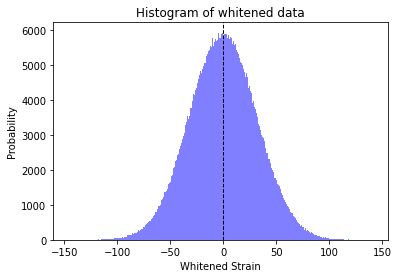

In [23]:
#creating a histogram
num_bins = 300 #set the number of desired bins 
plt.hist(data_whitened, num_bins, facecolor='blue', alpha=0.5) #creating the  histogram 

min_ylim, max_ylim = plt.ylim() 
plt.axvline(x = mean , color='k', linestyle='dashed', linewidth=1) #drawing a line at 0 to check if the mean of the whitened data is indeed 0 
#setting labels of the histogram
pylab.ylabel('Probability')
pylab.xlabel('Whitened Strain')
pylab.title('Histogram of whitened data')
pylab.show()